In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
groups_folder_path = "./images2/dachshund/"
groups_folder_path1 = "./images2/ducks/"
groups_folder_path2 = "./images2/fish/"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

def imglist(groups_folder_path_name):
    img_list = []
    for x in os.listdir(groups_folder_path_name):
      if x != '.ipynb_checkpoints':
        image_filename = groups_folder_path_name + x
        img = Image.open(image_filename)
        size = (512, 512)
        img = img.resize(size)
        img = np.array(img)
        img_list.append(img)
    return img_list


def imgrotate(imagelist):
   
   img_list = [] 
   for x in imagelist:
        img = Image.fromarray(x)
        img = img.rotate(30)
        img = np.array(img)
        img_list.append(img)
   return img_list


a = imglist(groups_folder_path)
a_r = imgrotate(a)
b = imglist(groups_folder_path1)
b_r = imgrotate(b)
c = imglist(groups_folder_path2)
c_r = imgrotate(c)
print(len(a), len(b), len(c))

X = np.concatenate((a,a_r, b,b_r,c, c_r), axis = 0)

num_classes = 3
Y = []
for i in range(3):
  label = [0 for i in range(num_classes)]
  label[i] = 1
  for _ in range(21):
     Y.append(label)
     Y.append(label)

Y = np.asarray(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print(X.shape, Y.shape)
X_test.shape, Y_test.shape

1 Physical GPUs, 1 Logical GPUs
21 21 21
(126, 512, 512, 3) (126, 3)


((32, 512, 512, 3), (32, 3))

In [2]:
def hard_swish(features):

  
  features = tf.convert_to_tensor(features)
  fdtype = features.dtype
  return features * tf.nn.relu6(features + tf.cast(3., fdtype)) * (1. / 6.)

  

In [3]:
def se_block(inputs, ch, ratio=16):

    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(ch//ratio, activation='relu')(x)
    y = tf.keras.layers.Dense(ch, activation='sigmoid')(x)
    y = tf.keras.layers.multiply([inputs, y])
    out = hard_swish(y)
    return out



In [4]:
def dep_bn(inputs, filter : int, kernel :int, stride: int):

  y = tf.keras.layers.Conv2D(filters = filter, kernel_size= kernel, strides= stride, padding= 'same')(inputs)
  bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
  relu = tf.nn.relu6(bn)
  
  return relu 


def Inverted_residual_SEblock(x, filter : int, kernel: int, strides = int):


    #pointwise
    y = tf.keras.layers.Conv2D(filters = filter, kernel_size=  1, strides = strides, padding= 'same')(x)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    y_p = tf.nn.relu6(bn)
    
    
    #depthwise
    y = tf.keras.layers.DepthwiseConv2D(kernel_size=  kernel, strides= strides, padding= 'same', depth_multiplier = 1)(y_p)
    bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
    y_d = tf.nn.relu6(bn)
   
   
    #pointwise
    y = tf.keras.layers.Conv2D(filters = filter, kernel_size= 1, strides=strides, padding= 'same')(y)
    y = tf.keras.layers.BatchNormalization(axis = 1)(y)
    out = tf.keras.layers.ReLU()(y)

    if strides == 1:
        if x.shape[3] != filter : 
           x = tf.keras.layers.Conv2D(filters = filter, kernel_size = 1, strides = strides, padding = "same")(x)
        out  = tf.keras.layers.Add()([x, out])
   
    y = se_block(out, filter)

    #pointwise
    y = tf.keras.layers.Conv2D(filters = filter, kernel_size= 1, strides=strides, padding= 'same')(y)
    y = tf.keras.layers.BatchNormalization(axis = 1)(y)
    out = tf.keras.layers.ReLU()(y)


    return out



In [5]:
def create_mobilenetV3(inputs):

   x = dep_bn(inputs, 16, 3, 2)
   x = Inverted_residual_SEblock(x, 16, 3, 1)
   x = Inverted_residual_SEblock(x, 16, 3, 2)
   x = Inverted_residual_SEblock(x, 24, 3, 1)
   x = Inverted_residual_SEblock(x, 24, 5, 2)
   x = Inverted_residual_SEblock(x, 40, 5, 1)
   x = Inverted_residual_SEblock(x, 40, 5, 1)
   x = Inverted_residual_SEblock(x, 40, 3, 2)
   x = Inverted_residual_SEblock(x, 80, 3, 1)
   x = Inverted_residual_SEblock(x, 80, 3, 1)
   x = Inverted_residual_SEblock(x, 80, 3, 1)
   x = Inverted_residual_SEblock(x, 80, 3, 1)
   x = Inverted_residual_SEblock(x, 112, 3, 1)
   x = Inverted_residual_SEblock(x, 112, 5, 1)
   x = Inverted_residual_SEblock(x, 160, 5, 1)
   x = dep_bn(x, 160, 1, 1)
   
   t = tf.keras.layers.AveragePooling2D(1)(x)
   t = tf.keras.layers.Flatten()(t)
   outputs = tf.keras.layers.Dense(3, activation='softmax')(t)
   return outputs


In [8]:
x = dep_bn(inputs, 16, 3, 2)
print(x)
x = Inverted_residual_SEblock(x, 16, 3, 1)
print(x)
Inverted_residual_SEblock(x, 16, 3, 2)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 16), dtype=tf.float32, name=None), name='tf.nn.relu6_44/Relu6:0', description="created by layer 'tf.nn.relu6_44'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 16), dtype=tf.float32, name=None), name='re_lu_29/Relu:0', description="created by layer 're_lu_29'")


<KerasTensor: shape=(None, 16, 16, 16) dtype=float32 (created by layer 're_lu_31')>

In [7]:
inputs = tf.keras.Input(shape=(X[0].shape[0], X[0].shape[0],3))
outputs = create_mobilenetV3(inputs)

model = tf.keras.Model(inputs, outputs)
EPOCHS = 40
INIT_LR = 1e-3
BS = 5
opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [9]:
outputs.shape

TensorShape([None, 3])

In [10]:
#model.summary()
model.fit(
    X_train,
    Y_train,
    epochs=40,
    verbose=1,
    validation_data=(X_test, Y_test),
    batch_size=5
)

Epoch 1/40
19/19 [==============================] - 10s 140ms/step - loss: 1.2391 - accuracy: 0.4215 - val_loss: 1.0984 - val_accuracy: 0.3750
Epoch 2/40
19/19 [==============================] - 1s 40ms/step - loss: 1.0606 - accuracy: 0.4246 - val_loss: 1.0968 - val_accuracy: 0.3750
Epoch 3/40
19/19 [==============================] - 1s 40ms/step - loss: 1.0932 - accuracy: 0.4201 - val_loss: 1.0955 - val_accuracy: 0.3750
Epoch 4/40
19/19 [==============================] - 1s 38ms/step - loss: 0.9545 - accuracy: 0.5772 - val_loss: 1.0976 - val_accuracy: 0.3750
Epoch 5/40
19/19 [==============================] - 1s 39ms/step - loss: 0.9045 - accuracy: 0.5219 - val_loss: 1.1007 - val_accuracy: 0.3750
Epoch 6/40
19/19 [==============================] - 1s 40ms/step - loss: 0.9857 - accuracy: 0.4936 - val_loss: 1.1142 - val_accuracy: 0.3750
Epoch 7/40
19/19 [==============================] - 1s 38ms/step - loss: 0.9366 - accuracy: 0.4978 - val_loss: 1.1227 - val_accuracy: 0.3750
Epoch 8/40


In [11]:
test = imglist('./images2/test/')
test = np.asarray(test)
test.shape
predictions = model.predict(test)
predictions

array([[3.50931863e-04, 1.60991121e-02, 9.83549953e-01],
       [4.47959393e-01, 5.25490284e-01, 2.65502930e-02],
       [1.79561577e-03, 6.66240156e-02, 9.31580365e-01],
       [2.89338699e-04, 1.34038366e-02, 9.86306846e-01],
       [2.68024672e-02, 4.74390298e-01, 4.98807251e-01],
       [2.89338699e-04, 1.34038366e-02, 9.86306846e-01],
       [3.22468323e-03, 1.05244346e-01, 8.91531050e-01],
       [2.78010331e-02, 4.84803230e-01, 4.87395734e-01],
       [8.09172576e-04, 3.41773145e-02, 9.65013564e-01],
       [2.40907837e-02, 4.44517642e-01, 5.31391561e-01],
       [2.64926944e-02, 4.71037984e-01, 5.02469361e-01],
       [1.04001528e-02, 2.53814757e-01, 7.35785127e-01]], dtype=float32)

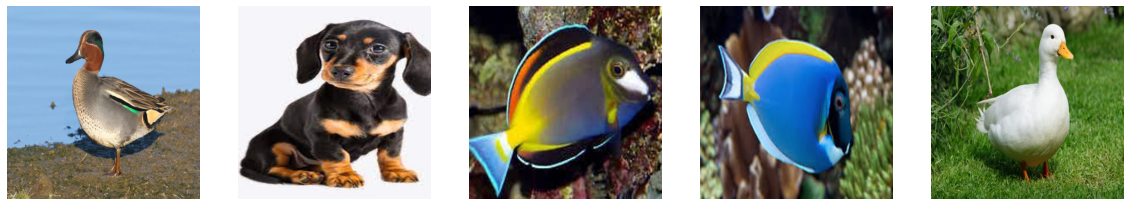

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(test[i])
    ax[i].axis('off')

In [13]:
def output_one_hot(prediction) :
    
   
    i = np.argmax(prediction)
    label_output = [0 for i in range(num_classes)]
    label_output[i] = 1
    return label_output

In [14]:
onehot_output = []
for pred in predictions:
    
    onehot_output.append(output_one_hot(pred))
print(onehot_output)

[[0, 0, 1], [0, 1, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
